# Analysis of transactions

In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.0f}'.format

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'browser'
# pio.renderers.default = "plotly_mimetype"

import yaml
from datetime import datetime as dt

import analysis_functions    # local functions in this repository

In [2]:
# read settings from config file
with open("config.ini", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)
clm = cfg['column names database'] | cfg['names result table']  # combine into one dictionary


# load transactions
transactions = pd.read_csv(cfg['CSV filenames']['database'] + '.csv', encoding = "ISO-8859-1", 
    parse_dates=[clm['date']], date_format=cfg['date format'])


# filter time

year = 2023
transactions = transactions.query('date.dt.year >= @year and date.dt.year < @year + 1')

# transactions = transactions[( transactions[clm['date']] >= dt(dt.today().year - 1 , dt.today().month , 1) )]

## table sum per month & category

In [3]:
sum_cat_month, df_plot_fine, df_plot_rough, df_sunburst = analysis_functions.get_sum_cat_month(transactions, clm)

sum_cat_month.replace(0, '')

# sum_cat_month.to_excel('Overview.xlsx')

date                             2023-01 2023-02 2023-03 2023-04 2023-05  \
category        type                                                       
flat            ancillary costs     -305     -76     -83     -76     -76   
                furniture            -43             -99    -119           
                rent              -1,000  -1,000  -1,000  -1,000  -1,000   
income                             2,800   2,800   2,800   2,800   2,800   
leisure         clubs               -113                                   
                food                                 -98    -115    -267   
                going out                           -200            -149   
                hobby                -20             -72     -34           
                sport                                -55                   
living expenses cash                -200                    -185    -186   
                clothes                             -118                   
                groceries           -237    -200    -314    -244    -336   
                insurance            -77            -403                   
                phone                 -5      -4      -4      -4      -4   
                presents                     -89                           
mobility        bicycle                                   -1,275           
                gas                  -58    -102    -174     -49    -111   
                maintenance         -423            -312                   
                parking              -85     -85    -106     -85     -85   
                public transport                     -23                   
savings         stocks              -200    -200  -1,200    -200    -200   
vacation        lodging                                             -269   
                transport                                                  
                various                                              -26   
EXPENSES                          -2,765  -1,756  -4,260  -3,386  -2,708   
SUM                                   35   1,044  -1,460    -586      92   

date                             2023-06 2023-07 2023-08 2023-09 2023-10  \
category        type                                                       
flat            ancillary costs      -76    -100    -100     -93     -93   
                furniture                    -18     -26                   
                rent              -1,000  -1,000  -1,000  -1,000  -1,000   
income                             2,800   2,800   2,800   2,800   2,800   
leisure         clubs                                                      
                food                -417     -36    -408     -55    -263   
                going out                                            -22   
                hobby                -62     -95      -4                   
                sport                                        -77      -7   
living expenses cash                        -160     -89    -100    -294   
                clothes                             -122                   
                groceries           -348    -236    -408    -153    -266   
                insurance                                                  
                phone                 -4      -5      -4      -4      -7   
                presents                            -307             -21   
mobility        bicycle                                                    
                gas                 -176     -61    -253     -39    -117   
                maintenance                                                
                parking             -109     -85     -97     -95     -85   
                public transport                                      -8   
savings         stocks              -200    -200    -200    -200    -200   
vacation        lodging                     -180  -1,245    -412     -60   
                transport           -204       

## plot

- balance over time

Balance over time:   603.28 €
Current balance:    3000.00 €
Average balance:    2843.55 €


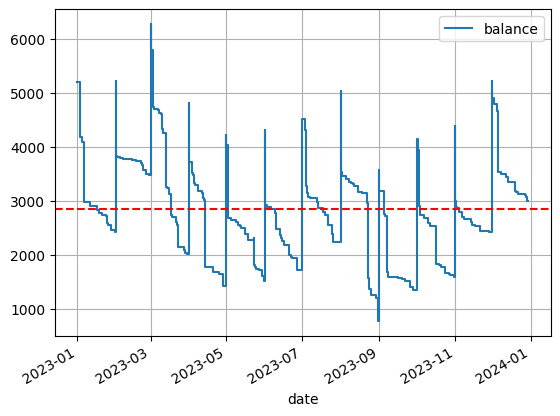

In [11]:
transactions.plot(clm['date'], clm['balance'], drawstyle='steps-post')
meanvalue = transactions.set_index(clm['date']).resample('1D').mean(numeric_only=True).ffill().mean()[clm['balance']]
plt.axhline(y=meanvalue, color='r', linestyle='--')
plt.grid()

balance = ( transactions.iloc[0 ][clm['amount' ]]
          + transactions.iloc[-1][clm['balance']]
          - transactions.iloc[0 ][clm['balance']] )
print(f"Balance over time: {balance:8.2f} €")

print(f"Current balance:   {transactions.iloc[-1][clm['balance']]:8.2f} €")
print(f"Average balance:   {meanvalue:8.2f} €")

Current balance: 3000.0 €


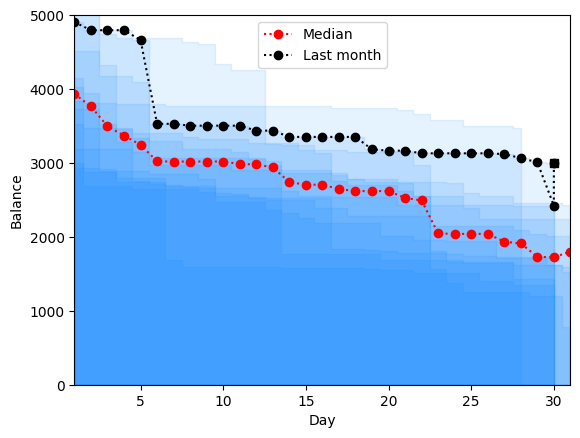

In [5]:
transactions_days = transactions.resample('1D', on=clm['date']).aggregate({clm['balance']: 'last'}).ffill().reset_index()

transactions_days['day']   = transactions_days[clm['date']].dt.day
transactions_days['month'] = transactions_days[clm['date']].dt.to_period('M')

for month in sorted(transactions_days['month'].unique()):
    transactions_month = transactions_days[transactions_days['month'] == month]
    plt.fill_between(transactions_month['day'], transactions_month[clm['balance']], step='mid', alpha=0.1, color=[0,.5,1])

transactions_median = transactions_days.groupby('day').aggregate({clm['balance']: 'median'}).reset_index()
plt.plot(transactions_median['day'], transactions_median[clm['balance']], 'ro:', label='Median')

transactions_last_month = transactions_days.iloc[-31:].sort_values('day')
plt.plot(transactions_last_month['day'],    transactions_last_month[clm['balance']]   , 'ko:', label='Last month')
plt.plot(transactions_days['day'].iloc[-1], transactions_days[clm['balance']].iloc[-1], 'ks')

plt.xlabel('Day')
plt.ylabel('Balance')
plt.legend(loc='upper center')
plt.xlim(1, 31)
plt.ylim(0, 5000)

print(f"Current balance: {transactions.iloc[-1][clm['balance']]} €")

- sunburst all categories

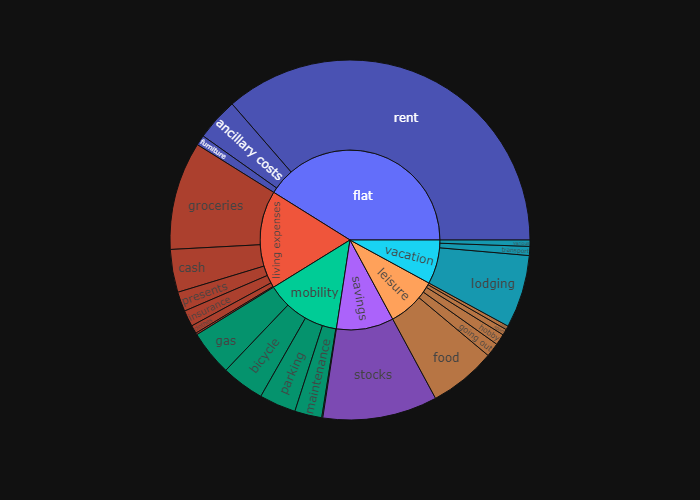

Total spendings: 32996 €


In [6]:
fig = px.sunburst(df_sunburst, path=[clm['category'], clm['cat_fine']], values=clm['sum'], template="plotly_dark")
fig.show('png')
# fig.show()

print(f"Total spendings: {int(df_sunburst[clm['sum']].sum())} €")

- all categories per month

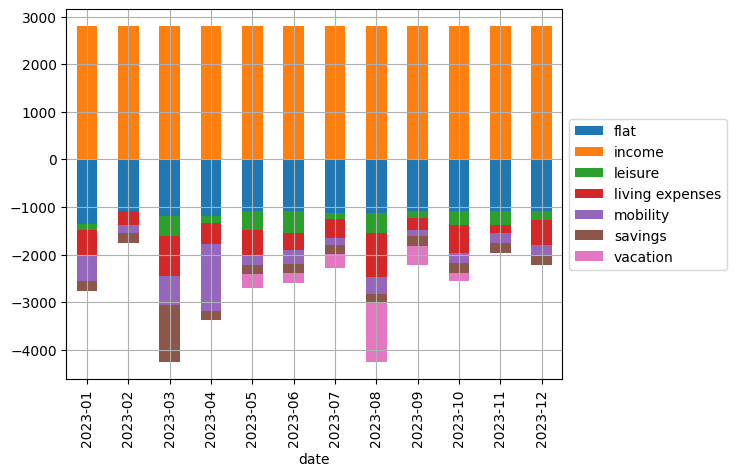

In [7]:
df_plot_rough.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid()

- saldo per month

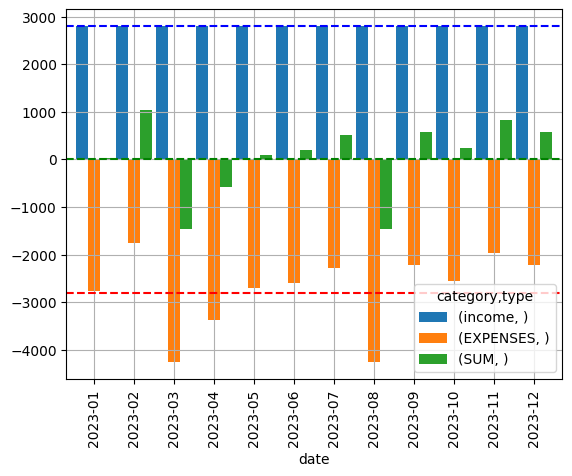

In [8]:
df_plot_fine.plot.bar(y=[ ('income','') , (clm['expenses'],'') , (clm['sum'],'') ] , width=0.9)
plt.axhline(y=sum_cat_month.loc[('income','')        , clm['mean_month']], color='b', linestyle='--')
plt.axhline(y=sum_cat_month.loc[(clm['expenses'],'') , clm['mean_month']], color='r', linestyle='--')
plt.axhline(y=sum_cat_month.loc[(clm['sum'],'')      , clm['mean_month']], color='g', linestyle='--')
plt.grid()

- individual categories per month

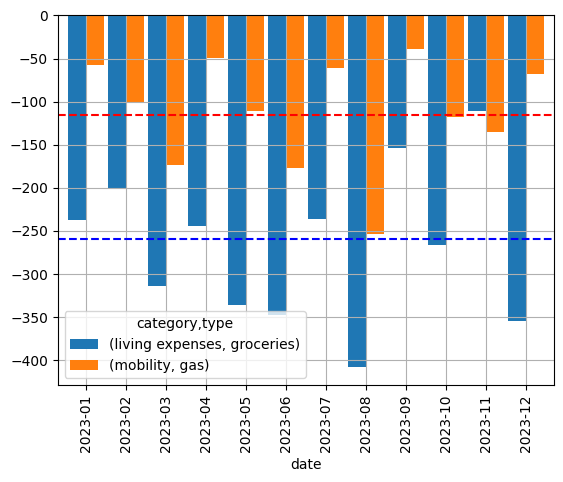

In [9]:
df_plot_fine.plot.bar(y=[ ('living expenses','groceries') , ('mobility','gas') ], width=0.9)
plt.axhline(y=sum_cat_month.loc[ ('living expenses','groceries') , clm['mean_month'] ], color='b', linestyle='--')
plt.axhline(y=sum_cat_month.loc[ ('mobility','gas')              , clm['mean_month'] ], color='r', linestyle='--')
plt.grid()